In [1]:
#import tensorflow as tf
#tf.__version__
#!conda install -y gdown
#!gdown --id 13t7OBZ1_cyQySXgyTgiIQVP6mu3DBJlT

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.0.12            |     pyh9f0ad1d_0          10 KB  conda-forge
    gdown-3.12.2               |     pyh9f0ad1d_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          22 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.0.12-pyh9f0ad1d_0
  gdown              conda-forge/noarch::gdown-3.12.2-pyh9f0ad1d_0



gdown-3.12.2         | 12 KB     | ##################################### | 100% 
filelock-3.0.12      | 10 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Downloading...

In [3]:
%load_ext tensorboard
%matplotlib inline

import io
import os
import argparse
from glob import glob
import matplotlib.pyplot as plt
import IPython.display as display
import imageio
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras import Model, layers, losses, metrics, regularizers, optimizers, initializers
from tensorflow.keras.utils import plot_model

# Default paths.
SCRIPT_PATH = './WGAN_GP'
EXPERIMENT_ID = 'EXP_2'
MODEL_SAVE_PATH = os.path.join(SCRIPT_PATH, EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
IMG_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, 'generated_img')
if not os.path.exists(IMG_SAVE_PATH):
    os.makedirs(IMG_SAVE_PATH)

DEFAULT_TFRECORDS_DIR = '../input/dcgan-dataset'
DEFAULT_NUM_EPOCHS = 2000
DEFAULT_LEARNING_RATE = 1e-4
DEFAULT_BATCH_SIZE = 64
DEFAULT_SAVE_PERIOD = 15
DEFAULT_LATENT_DEPTH = 100

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNEL = 3
NUM_INPUT_DATA = 8960

# Parameters for THE CRITIC
N_CRITIC = 5
GRADIENT_PENALTY_WEIGHT = 10.0

args = None

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--tfrecords-dir', type=str, dest='tfrecords_dir',
                        default=DEFAULT_TFRECORDS_DIR,
                        help='Directory of TFRecords files.')
parser.add_argument('--num-train-epochs', type=int,
                        dest='num_train_epochs',
                        default=DEFAULT_NUM_EPOCHS,
                        help='Number of times to iterate over all of the '
                             'training data.')
parser.add_argument('--learning-rate', type=float,
                        dest='learning_rate',
                        default=DEFAULT_LEARNING_RATE,
                        help='How large a learning rate to use when training.')
parser.add_argument('--batch-size', type=int,
                        dest='batch_size',
                        default=DEFAULT_BATCH_SIZE,
                        help='How many images to train on at a time.')
parser.add_argument('--save-period', type=int,
                        dest='save_period',
                        default=DEFAULT_SAVE_PERIOD,
                        help='How many epochs to save ckpt files.')
parser.add_argument('--latent-depth', type=int,
                        dest='latent_depth',
                        default=DEFAULT_LATENT_DEPTH,
                        help='How many latent variables you have.')
args = parser.parse_args('')

In [5]:
def _parse_function(example):
    features = tf.io.parse_single_example(
        example,
        features={
            'filename': tf.io.FixedLenFeature([], tf.string, default_value = ''),
            'image/encoded': tf.io.FixedLenFeature([], tf.string,
                                                default_value='')
        })
    image_encoded = features['image/encoded']

    # Decode the JPEG.
    image = tf.io.decode_jpeg(image_encoded, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = image*2.0-1.0

    return image

In [6]:
train_data_files = glob(os.path.join(args.tfrecords_dir, 'train-*'))
train_dataset = tf.data.TFRecordDataset(train_data_files) \
        .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

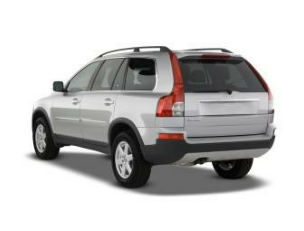

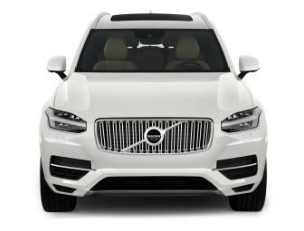

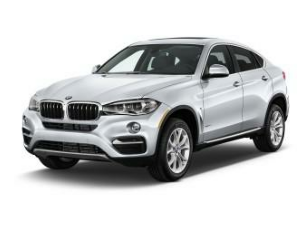

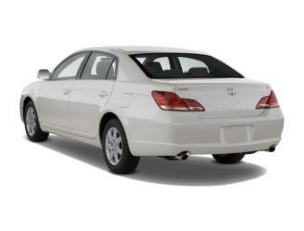

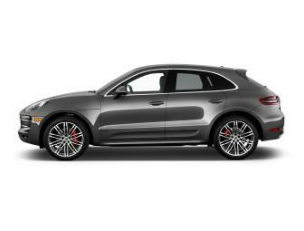

In [7]:
for img in train_dataset.take(5):
    img = (img+1.0)/2.0
    img_np = img.numpy()
    plt.figure()
    plt.axis('off')
    plt.imshow(img_np)

In [8]:
def preprocessing_data(image):
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return image

In [9]:
train_dataset = train_dataset.map(preprocessing_data) \
        .cache() \
        .shuffle(NUM_INPUT_DATA) \
        .batch(args.batch_size) \
        .prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
def generator_model():
    inputs = layers.Input(shape=(args.latent_depth,))
    x = layers.Dense(8*8*512)(inputs)
    x = layers.Reshape((8, 8, 512))(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.ReLU()(x)
    

    x = layers.Conv2DTranspose(256, 3, 2, padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, 3, 2, padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, 2, padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(3, 3, 2, padding='same', activation = 'tanh', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)

    model = Model(inputs, x, name="generator")
    model.summary()
    plot_model(model, to_file=os.path.join(MODEL_SAVE_PATH, "generator.png"), show_shapes=True)
    return model

In [11]:
def discriminator_model():
    inputs = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
    x = layers.Conv2D(32, 5, 2, padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(64, 5, 2, padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 5, 2, padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 5, 2, padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    x = layers.LeakyReLU(0.2)(x)
 
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
 
    model = Model(inputs, x, name="discriminator")
    model.summary()
    plot_model(model, to_file=os.path.join(MODEL_SAVE_PATH, "discriminator.png"), show_shapes=True)
    return model

In [12]:
def gradient_penalty(discriminator, real_images, fake_images):
    """ Calculates the gradient penalty.
    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # get the interplated image
    epsilon = tf.random.normal([tf.shape(real_images)[0], 1, 1, 1], 0.0, 1.0)
    x_hat = epsilon * real_images + (1 - epsilon) * fake_images
    with tf.GradientTape() as t:
        t.watch(x_hat)
        # 1. Get the discriminator output for this interpolated image.
        d_hat = discriminator(x_hat)
    # 2. Calculate the gradients w.r.t to this interpolated image.
    gradients = t.gradient(d_hat, x_hat)
    # 3. Calcuate the norm of the gradients
    ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
    gp = tf.reduce_mean((ddx - 1.0) ** 2)
    return gp

In [13]:
class WGAN_GP(tf.keras.Model):
    def __init__(self):
        super(WGAN_GP, self).__init__()
        self.input_layer = layers.Input(shape=(args.latent_depth,))
        self.generator = generator_model()
        self.discriminator = discriminator_model()
        self.out = self.call(self.input_layer)
        super(WGAN_GP, self).__init__(inputs = self.input_layer, outputs = self.out, name='wgan_gp')
 
        self.d_loss_tracker = metrics.Mean(name='losses/d_loss')
        self.g_loss_tracker = metrics.Mean(name='losses/g_loss')
        self.d_norm_grad_tracker = metrics.Mean(name='grads/d_norm_grad')
        self.g_norm_grad_tracker = metrics.Mean(name='grads/g_norm_grad')

    def build(self, input_shape, **kwags):
        super(WGAN_GP, self).build(input_shape, **kwags)
 
    def call(self, inputs, training=False):
        images = self.generator(inputs, training)
        outputs = self.discriminator(images, training)
        return images, outputs
 
    def compile(self, d_optimizer, g_optimizer, **kwags):
        super(WGAN_GP, self).compile(**kwags)
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
 
    @tf.function
    def train_step(self, real_images):
        
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, args.latent_depth))
 
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors, training=True)

        # Add random noise to the labels - important trick!
        #labels += 0.05 * tf.random.uniform(tf.shape(labels))
 
        # Train the discriminator
        with tf.GradientTape() as tape:
            r_logit = self.discriminator(real_images, training=True)
            f_logit = self.discriminator(generated_images, training=True)
            d_loss = - tf.math.reduce_mean(r_logit)+tf.math.reduce_mean(f_logit)
            gp = gradient_penalty(self.discriminator, real_images, generated_images)        
            d_loss += gp * GRADIENT_PENALTY_WEIGHT

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        self.d_loss_tracker.update_state(d_loss)
        self.d_norm_grad_tracker.update_state(tf.math.log(tf.linalg.global_norm(grads)))
        
        if self.d_optimizer.iterations % N_CRITIC == 0:

            # Sample random points in the latent space
            random_latent_vectors = tf.random.normal(shape=(batch_size, args.latent_depth))

            with tf.GradientTape() as tape:
                # Decode them to fake images
                generated_images = self.generator(random_latent_vectors, training=True)

                f_logit = self.discriminator(generated_images, training=True)
                g_loss = - tf.math.reduce_mean(f_logit)

            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

            self.g_loss_tracker.update_state(g_loss)
            self.g_norm_grad_tracker.update_state(tf.math.log(tf.linalg.global_norm(grads)))

        return {"losses/d_loss": self.d_loss_tracker.result(), "losses/g_loss": self.g_loss_tracker.result()}
 
    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker, self.g_norm_grad_tracker, self.d_norm_grad_tracker]

In [14]:
def wgan_gp_model():
    model = WGAN_GP()
    model.summary()
    plot_model(model, to_file=os.path.join(MODEL_SAVE_PATH, "wgan_gp.png"), show_shapes=True)
    return model

In [15]:
model = wgan_gp_model()

generator_optimizer = tf.keras.optimizers.Adam(lr=args.learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=args.learning_rate)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 32768)             3309568   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       10

In [16]:
sample_noise = tf.random.stateless_normal([4, 1, args.latent_depth], seed = [40, 40])

def generate_and_save_images(model, epoch):

    plt.figure(figsize=(15,10))

    for i in range(4):
        images, _ = model(sample_noise[i], training=False)
        
        image = images[0, :, :, :]
        image = np.reshape(image, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
        image = (image+1.0)/2.0

        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Epoch_{:04d}'.format(epoch))

    plt.tight_layout()  
    plt.savefig(os.path.join(IMG_SAVE_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

In [17]:
train_summary_writer = tf.summary.create_file_writer(os.path.join(MODEL_SAVE_PATH, 'summaries', 'train'))

class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, ckpt, manager, period):
        super(MyCallback, self).__init__()
        self.period = period
        self.ckpt = ckpt
        self.epoch = int(ckpt.epoch)
        self.manager = manager

    def on_epoch_begin(self, epoch, logs=None):
        self.ckpt.epoch.assign_add(1)
        self.epoch += 1
    
    def on_epoch_end(self, epoch, logs=None):
        with train_summary_writer.as_default():
            for metric in self.model.metrics:
                tf.summary.scalar(metric.name, metric.result(), step=self.epoch)
          
        if  self.epoch % self.period == 0:
            display.clear_output(wait=True)
            generate_and_save_images(self.model, self.epoch)
            save_path = self.manager.save()
            
            print("Saved checkpoint for epoch {}: {}".format(self.epoch, save_path))

In [18]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './WGAN_GP/EXP_2/summaries/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-02-15 04:57:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.209.238.187, 52.5.208.118, 52.22.246.104, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.209.238.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  22.5MB/s    in 0.6s    

2021-02-15 04:57:46 (22.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://987c06bd466b.ngrok.io


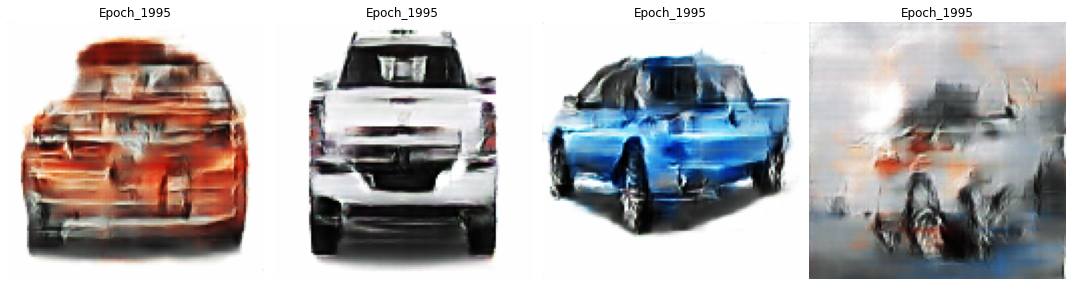

Saved checkpoint for epoch 1995: ./WGAN_GP/EXP_2/ckpt/ckpt-133
Epoch 1996/2000
140/140 [==============================] - 13s 93ms/step - losses/d_loss: -58.9989 - losses/g_loss: 1.6625
Epoch 1997/2000
140/140 [==============================] - 13s 93ms/step - losses/d_loss: -59.1362 - losses/g_loss: 11.3273
Epoch 1998/2000
140/140 [==============================] - 13s 94ms/step - losses/d_loss: -58.6575 - losses/g_loss: -7.7824
Epoch 1999/2000
140/140 [==============================] - 13s 93ms/step - losses/d_loss: -58.5385 - losses/g_loss: -2.4244
Epoch 2000/2000
140/140 [==============================] - 13s 93ms/step - losses/d_loss: -59.6158 - losses/g_loss: 15.3348
Learning finished!


'\nmodel.evaluate(\n    test_dataset\n)\n'

In [19]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 model = model)
manager = tf.train.CheckpointManager(ckpt, os.path.join(MODEL_SAVE_PATH, 'ckpt'), max_to_keep=3)
if manager.latest_checkpoint:
    status = ckpt.restore(manager.latest_checkpoint)
    status.assert_existing_objects_matched()
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")
 
model.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)
 
my_callback = MyCallback(ckpt, manager, args.save_period)

print('Start learning!')
model.fit(
    train_dataset,
    epochs = args.num_train_epochs,
    callbacks = [my_callback],
    initial_epoch = int(ckpt.epoch),
)
print('Learning finished!')
 
'''
model.evaluate(
    test_dataset
)
'''

In [20]:
anim_file = os.path.join(MODEL_SAVE_PATH, 'wgan_gp.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob(os.path.join(IMG_SAVE_PATH, '*.png'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

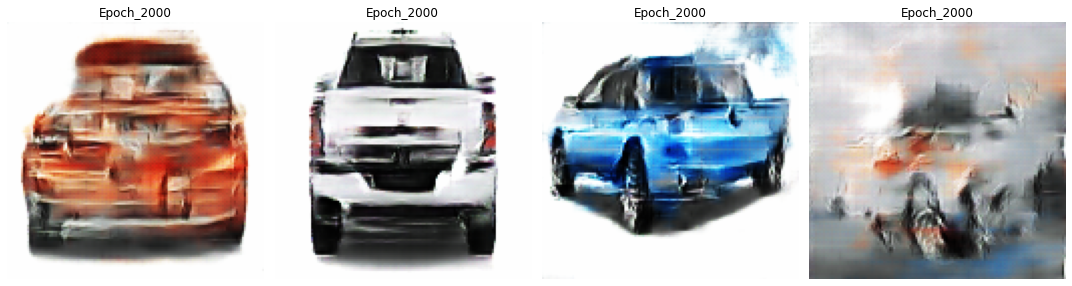

wgan_gp.pb file is created successfully!!


In [21]:
display.clear_output(wait=True)
generate_and_save_images(model, int(ckpt.epoch))

tf.saved_model.save(model, os.path.join(MODEL_SAVE_PATH, 'wgan_gp'))
print('wgan_gp.pb file is created successfully!!')